In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

### Connect to database

In [2]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver = 'SQL+Server'
string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}" 
try: 
    conn = create_engine(string1).connect()
except:
    try:
        driver = 'ODBC+Driver+18+for+SQL+Server'
        string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}"   
        conn = create_engine(string2).connect() 
    except:
        import pymssql
        string = f"mssql+pymssql://{username}:{password}@{server}/{database}"   
        conn = create_engine(string).connect() 

### Get adjusted closing prices and calculate returns and returns in excess of median

In [3]:
import pandas as pd 
price = pd.read_sql(
    """ 
    select date, ticker, closeadj from sep_weekly 
    where date>='2010-01-01'
    order by ticker, date  
    """,
    conn,
    parse_dates = ["date"],
    index_col = ["ticker", "date"]
)

ret = price.groupby("ticker", group_keys=False).pct_change()
target = ret.groupby("date", group_keys=False).apply(lambda x: x - x.median())

### Compute moving averages and logs of ratios

- Compute 4 week, 13 week, 26 week, and 52 week moving averages
- Define logs of ratios to use as predictors:
  - current price / 4 week moving avg
  - 4 week moving avg / 13 week moving avg
  - 13 week moving avg / 26 week moving avg
  - 26 week moving avg / 52 week moving avg

In [4]:
ma4 = price.groupby("ticker", group_keys=False).rolling(4).closeadj.mean()
ma13 = price.groupby("ticker", group_keys=False).rolling(13).closeadj.mean()
ma26 = price.groupby("ticker", group_keys=False).rolling(26).closeadj.mean()
ma52 = price.groupby("ticker", group_keys=False).rolling(52).closeadj.mean()
for d in [ma4, ma13, ma26, ma52]:
    d.index = d.index.droplevel(0)
p4 = np.log(price.closeadj/ma4)
p13 = np.log(ma4/ma13)
p26 = np.log(ma13/ma26)
p52 = np.log(ma26/ma52)

### Compute dummy variables for crossovers as additional predictors

Log of ratio switches sign when crossovers happen

- ratio switches from <1 to >1 when short term moves above long term
  - log of ratio switches from  <0 to >0 when this happens
- ratio switches from >1 to <1 when short term moves below long term
  - log of ratio switches from >0 to <0 when this happens

In [5]:
p4_lag = p4.groupby("ticker", group_keys=False).shift()
p13_lag = p13.groupby("ticker", group_keys=False).shift()
p26_lag = p26.groupby("ticker", group_keys=False).shift()
p52_lag = p52.groupby("ticker", group_keys=False).shift()

a4 = 1 * ((p4_lag<0) & (p4>0))
b4 = 1 * ((p4_lag>0) & (p4<0))
a13 = 1 * ((p13_lag<0) & (p13>0))
b13 = 1 * ((p13_lag>0) & (p13<0))
a26 = 1 * ((p26_lag<0) & (p26>0))
b26 = 1 * ((p26_lag>0) & (p26<0))
a52 = 1 * ((p52_lag<0) & (p52>0))
b52 = 1 * ((p52_lag>0) & (p52<0))

### Example

- Look at 4 week and 13 week moving averages for AAPL since 2022.
- One of the predictors is p13 = log(ma4/ma13)
- Another predictor is a13 = 1 when ma4 crosses ma13 from below (and a13 = 0 otherwise)
- Another predictor is b13 = 1 when ma4 crosses ma13 from above (and b13 = 0 otherwise)

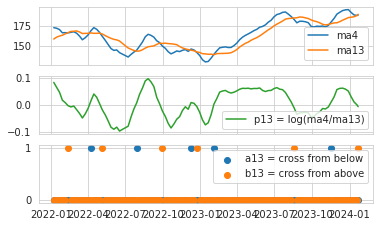

In [6]:
aapl_ma4 = ma4.xs("AAPL", level="ticker").loc["2022-01-01":]
aapl_ma13 = ma13.xs("AAPL", level="ticker").loc["2022-01-01":]
aapl_p13 = p13.xs("AAPL", level="ticker").loc["2022-01-01":]
aapl_a13 = a13.xs("AAPL", level="ticker").loc["2022-01-01":].reset_index()
aapl_b13 = b13.xs("AAPL", level="ticker").loc["2022-01-01":].reset_index()

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
aapl_ma4.plot(label="ma4", ax=ax1)
aapl_ma13.plot(label="ma13", ax=ax1)
ax1.legend()

aapl_p13.plot(label="p13 = log(ma4/ma13)", ax=ax2, c=sns.color_palette()[2])
ax2.legend()

plt.scatter(x=aapl_a13.date, y=aapl_a13.closeadj, label="a13 = cross from below")
plt.scatter(x=aapl_b13.date, y=aapl_b13.closeadj, label="b13 = cross from above")
ax3.legend()
plt.show()

### Combine return, target, and predictors (and filter to price >= 10)

In [7]:
df = pd.concat(
    (
        ret, target, price.closeadj, p4, p13, p26, p52,
        a4, b4, a13, b13, a26, b26, a52, b52
    ),
    axis=1
)
df.columns = [
    "ret", "target", "price", "p4", "p13", "p26", "p52",
    "a4", "b4", "a13", "b13", "a26", "b26", "a52", "b52"
]
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df["target"] = df.groupby("ticker", group_keys=False).target.shift(-1)

df = df[df.price>=10]
df = df.dropna()
df = df.reset_index()

df["year"] = df.date.map(lambda x: x.year)
df = df.sort_values(by=["date", "ticker"])
df.to_csv("df.csv")

### Linear regression

In [8]:
string = """
    target ~ p4 + p13 + p26 + p52 
    + a4 + b4 + a13 + b13 + a26 + b26 + a52 + b52
"""
result = smf.ols(string, df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     384.5
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        14:23:54   Log-Likelihood:             2.3873e+06
No. Observations:             1989729   AIC:                        -4.775e+06
Df Residuals:                 1989716   BIC:                        -4.774e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0018   6.58e-05     27.413      0.000       0.002       0.002
p4            -0.0470      0.001    -53.426      0.000      -0.049      -0.045
p13           -0.0005      0.001     -0.893      0.372      -0.002       0.001
p26           -0.0008      0.001     -1.252      0.211      -0.002       0.000
p52            0.0112      0.000     27.796      0.000       0.010       0.012
a4            -0.0013      0.000     -8.969      0.000      -0.002      -0.001
b4             0.0002      0.000      1.206      0.228      -0.000       0.000
a13            0.0011      0.000      4.270      0.000       0.001       0.002
b13           -0.0010      0.000     -3.916      0.000      -0.001      -0.000
a26            0.0012      0.000      3.348      0.001       0.001       0.002
b26           -0.0012      0.000     -3.112      0.002      -0.002      -0.000
a52            0.0009      0.001      1.798      0.072   -8.48e-05       0.002
b52            0.0012      0.001      2.205      0.027       0.000       0.002
==============================================================================
Omnibus:                  4525836.900   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     666365215332.942
Skew:                          20.571   Prob(JB):                         0.00
Kurtosis:                    2837.778   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Backtest a random forest

In [9]:
features = [
    "p4", "p13", "p26", "p52", 
    "a4", "b4", "a13", "b13", "a26", "b26", "a52", "b52"   
]
df2 = None 
forest = RandomForestRegressor(max_depth=4)

for year in range(2014, 2024):
    print(year)
    start = df[df.year == year].date.min()
    past = df[df.date < start]
    future = df[df.year == year].copy()
    forest.fit(X=past[features], y=past["target"])
    future["predict"] = forest.predict(X=future[features])
    df2 = pd.concat((df2, future))

df2.to_csv("df2.csv", index=False)
df2.head()

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


,ticker,date,ret,target,price,p4,p13,p26,p52,a4,b4,a13,b13,a26,b26,a52,b52,year,predict
158,A,2014-01-03,-0.011847,-0.009009,38.070,0.019850,0.054080,0.058452,0.075267,0,0,0,0,0,0,0,0,2014,0.001310
1985,AAMC,2014-01-03,0.008446,0.011284,543.935,-0.036612,0.237987,0.307785,0.418324,0,0,0,0,0,0,0,0,2014,0.002171
2779,AAON,2014-01-03,-0.016095,-0.013257,13.110,0.011045,0.094883,0.073265,0.168794,0,0,0,0,0,0,0,0,2014,0.001571
3462,AAP,2014-01-03,0.019802,0.022640,99.836,0.002871,0.074990,0.102951,0.065955,0,0,0,0,0,0,0,0,2014,0.001648
4203,AAPL,2014-01-03,-0.030513,-0.027676,17.566,-0.000996,0.049799,0.068881,0.062808,0,1,0,0,0,0,0,0,2014,0.001707


### Compute portfolio returns

- Equally weighted portfolio of 100 best stocks
- Equally weighted portfolio of 100 worst stocks
- Equally weighted portfolio of all stocks

In [10]:
starting_from_best = df2.groupby(
    "date", 
    group_keys=False
).predict.rank(
    ascending=False, 
    method="first"
)
best = df2[starting_from_best <= 100]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

starting_from_worst = df2.groupby(
    "date", 
    group_keys=False
).predict.rank(
    ascending=True, 
    method="first"
)
worst = df2[starting_from_worst <= 100]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

all_rets = df2.groupby("date", group_keys=True).ret.mean()
all_rets.index = pd.to_datetime(all_rets.index)

### Plot performance

- Set logy = True to get a log plot.  
- In a log plot, the slope of a curve represents the percent change in the y variable per unit change in the x variable.

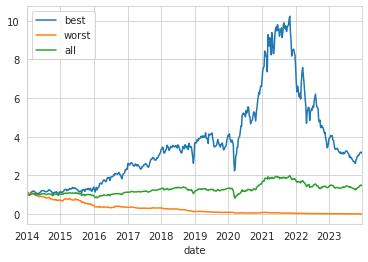

In [11]:
logy = False 

(1+best_rets).cumprod().plot(label="best", logy=logy)
(1+worst_rets).cumprod().plot(label="worst", logy=logy)
(1+all_rets).cumprod().plot(label="all", logy=logy)
plt.legend()
plt.show()

### Compare features of best and worst stocks

Look at portfolios on final date of backtest.

In [12]:
best_today = best[best.date == best.date.max()]
worst_today = worst[worst.date == worst.date.max()]

b = best_today[features].describe().iloc[1:].T
b.index.name = "stat"
b["group"] = "best"
b = b.reset_index().set_index(["stat", "group"])

w = worst_today[features].describe().iloc[1:].T
w.index.name = "stat"
w["group"] = "worst"
w = w.reset_index().set_index(["stat", "group"])

d = pd.concat((b, w))
d = d.unstack()
d.round(2)

mean         std         min         25%         50%         75%        \
group  best worst  best worst  best worst  best worst  best worst  best worst   
stat                                                                            
a13    0.01  0.14  0.10  0.35  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
a26    0.04  0.08  0.20  0.27  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
a4     0.06  0.06  0.24  0.24  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
a52    0.01  0.02  0.10  0.14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
b13    0.02  0.01  0.14  0.10  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
b26    0.01  0.01  0.10  0.10  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
b4     0.39  0.00  0.49  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00   
b52    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
p13    0.04  0.15  0.07  0.17 -0.13 -0.58  0.00  0.07  0.03  0.13  0.08  0.25   
p26   -0.02 -0.06  0.07  0.17 -0.27 -0.91 -0.04 -0.13 -0.01 -0.04  0.01  0.02   
p4    -0.01  0.14  0.02  0.07 -0.09  0.07 -0.02  0.10 -0.01  0.12 -0.00  0.16   
p52   -0.00 -0.13  0.09  0.46 -0.22 -3.43 -0.04 -0.16  0.01 -0.07  0.03  0.04   

        max        
group  best worst  
stat               
a13    1.00  1.00  
a26    1.00  1.00  
a4     1.00  1.00  
a52    1.00  1.00  
b13    1.00  1.00  
b26    1.00  1.00  
b4     1.00  0.00  
b52    0.00  0.00  
p13    0.43  0.67  
p26    0.12  0.39  
p4     0.00  0.51  
p52    0.50  0.29

### Plot distributions of individual features

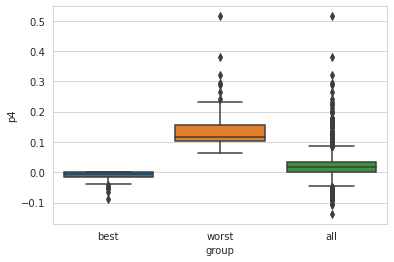

In [18]:
feature = "p4"

all_today = df[df.date == best.date.max()]
b2 = pd.DataFrame(best_today[feature])
b2["group"] = "best"
w2 = pd.DataFrame(worst_today[feature])
w2["group"] = "worst"
a2 = pd.DataFrame(all_today[feature])
a2["group"] = "all"
d2 = pd.concat((b2, w2, a2))
sns.boxplot(data=d2, x="group", y=feature)
plt.show()

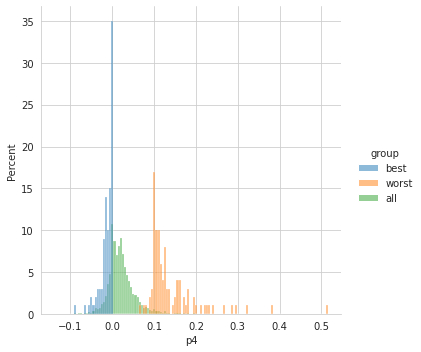

In [19]:
sns.displot(x=feature, hue="group", stat="percent", common_norm=False, data=d2)
plt.show()